This notebook implements many differents solutions for the PLN model. This is more a test of the  differents methods since we are building ourselves the data, and we know the true parameter Sigma and beta. This is just to check the method. The best solution is implemented in the fastPLN.py file for any data. An example is done at the end of the notebook. 

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from IMPS.utils import MSE,Poisson_reg, sample_PLN, sigmoid, logit, log_stirling

import matplotlib.pyplot as plt
from pandas import read_csv
import math 
import time 
plt.style.use('ggplot')

import threading

import numpy as np
import seaborn as sns 
import torch
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

ModuleNotFoundError: No module named 'IMPS'

In [474]:
torch.set_printoptions(precision=4)
#torch.set_default_dtype(torch.float64)

In [4]:
#get the device. can be used with GPU
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [477]:
def launch_optimizers(dict_optimizers,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = PLN_full(class_optimizer = optimizer)
        t = threading.Thread(target =model.full_grad_ascent_PCA,
              args = [data, N_iter          ,lr     , False] )
        #t = threading.Thread(target =model.VEM_both_closed,
        #      args = [data, N_iter           ,Nb_each_iter      , lr,  0.01 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
    return dict(zip(dict_optimizers.keys(), models))

def launch_lr(dict_lr,N_iter, optimizer = torch.optim.Rprop): 
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_lr : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         optimizer : the optimizer we want to use for the model
    '''
    ts = list()
    models = list()
    Nb_each_iter = 1
    for name, lr in dict_lr.items(): 
        model = PLN_full(class_optimizer = optimizer)
        #t = threading.Thread(target =model.full_grad_ascent_PCA, ## uncomment this if you want to use the PCA
        #      args = [data, N_iter          ,lr     , False] )   ## parametrization.
        t = threading.Thread(target =model.VEM_both_closed,
              args = [data, N_iter, Nb_each_iter,       lr,  0 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_lr.keys(), models))




    
def show_Sigma(dict_model): 
    for name,model in dict_model.items():
        print('model : ', name)
        try : 
            sns.heatmap(model.get_Sigma())
            plt.show()
            print(' MSE : ', np.mean((model.get_Sigma()- true_Sigma.numpy())**2))
        except : pass 
    print('true Sigma : ', sns.heatmap(true_Sigma.numpy()))
    


def launch_models(class_optim,N_iter, lr,Nb_each_iter = 8): 
    ''' 
    launch all the models. we use parallelization to go faster. 
    args : 
        class_optim : class of optimizer. should be torch.optim.Rprop for instance. 
        lr : float. learing rate of the optimizer. 
        Nb_each_iter : int. the number of iteration for each VEM step. 
    '''
    model_VEM_beta = PLN_full( class_optimizer = class_optim)
    model_VEM_Sigma = PLN_full( class_optimizer = class_optim)
    model_VEM_both = PLN_full(class_optimizer = class_optim)
    model_full = PLN_full( class_optimizer = class_optim)
    model_PCA = PLN_full(class_optimizer = class_optim)
    model_first = PLN_full(class_optimizer = class_optim)
    model_profile = PLN_full(class_optimizer = class_optim)
    
    t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
              args = [data, N_iter           ,Nb_each_iter            ,1/3*lr            , 0.1, False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
              args = [data, N_iter           ,Nb_each_iter     ,lr, 0.1             , False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , True] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_full = threading.Thread(target =model_full.full_grad_ascent,
              args = [data, N_iter*8           ,lr     , False] )
                     #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 

    t_PCA = threading.Thread(target =model_PCA.full_grad_ascent_PCA, 
             args = [data,  N_iter*8,   lr,              False])
    t_first =  threading.Thread(target =model_first.first_VEM,
              args = [data, N_iter           ,Nb_each_iter              ,lr     , 0.1             , False] )

    t_profile = threading.Thread(target = model_profile.profile_grad_ascent, 
                        args =[data, N_iter*13, 3*lr, False ] )

    t0 = time.time()
    
    
    #we launch all the models
    t_beta.start()
    t_Sigma.start()
    t_both.start()
    t_full.start()
    t_PCA.start()
    t_first.start()
    #t_profile.start()

    
    #we wait for the models to finish
    t_beta.join()
    t_Sigma.join()
    t_both.join()
    t_full.join()
    t_PCA.join()
    #t_profile.join()
    t_first.join()
    print('Execution time : ', time.time()-t0)

    dict_models = {'1' :model_VEM_both,'2' : model_full,'3' : model_first, 
                   '4' : model_VEM_Sigma,'5': model_PCA , '6' : model_VEM_beta
                  }
    return dict_models

def compare_models(dict_models,name_doss, percentage_kept = 1, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        'name_doss' : str. the name of the file you want to save the graphic. 
        'percentage_kept' float . should be positive and lower than 1
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    plt.subplots_adjust(hspace = 0.4)
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        
        length = len(abscisse)
        ax[2].plot(abscisse[-int(length*percentage_kept):], model.ELBO_list[-int(length*percentage_kept):], label = name )

        
    
    
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
    ax[0].legend()
    ax[0].set_title(r'MSE $(\Sigma-\hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylabel('MSE')
    ax[0].set_yscale('log')
    
    
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
    ax[1].legend()
    ax[1].set_xlabel('Seconds')
    ax[1].set_ylabel('MSE')
    ax[1].set_yscale('log')
    ax[1].set_title(r'MSE $(\beta- \hat {\beta})$') 

    ax[2].legend()
    ax[2].set_title('ELBO')
    ax[2].set_ylabel('ELBO')
    ax[2].set_xlabel('Seconds')
    ax[2].set_yscale('symlog')
    
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [5]:
def vec2mat_lower_tridiag(vectC):
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n)).to(device)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+2# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    coef_toep = 0.9
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(coef_toep**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(coef_toep**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

In [6]:
# Here are the gradients with the parametrisation centered in X\beta and variance C@C.T above. 
# we compute it just as a sanity check since it is computed with pytorch
def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T

def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad

In [7]:
#Here we compute the ELBO for all the different parametrization


######## Parametrisation centered in 0 and unit variance #########
def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO from the PCA parametrisation. 
    '''
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    first = torch.sum(torch.multiply(Y,A))
    second = torch.sum(-1/2*torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T)))
    third = torch.sum(+1/2*torch.log(SrondS))
    fourth = torch.sum(-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return first +second + third + fourth


###### parametrisation centered in X@beta and variance C@C.T ######



def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''

    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C in argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO with this matrix.
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)


####### parametrisation centered in 0 and Variance Sigma ##########




def first_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    ''' 
    computes the ELBO. We simply apply the formula given above. 
    '''
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    tmp = -n/2*torch.log(torch.det(Sigma)) #-1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))
    tmp += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    tmp -= 1/2*torch.trace(torch.mm(torch.mm(M.T, M) + torch.diag(torch.sum(SrondS, dim = 0)), inv_Sigma))
    tmp += 1/2*torch.sum(torch.log(SrondS))
    return tmp

def profile_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    '''
    computes the profiled ELBO. We replaced Sigma with its closed form to 
    avoid computing the inverse of Sigma. Should be faster, but does not work very well in practice. 
    Indeed, we have some nan values that appears for large values of p. 
    '''
    n = Y.shape[0]
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    J = -n/2*torch.log(torch.det(Sigma))
    J  += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    J-= n*p/2
    J += 1/2*torch.sum(torch.log(SrondS))
    return J 


########## parametrisation centered in X@beta and variance Sigma #########






    

In [8]:
class PLN_full():
    def __init__(self, class_optimizer = torch.optim.Rprop): 
        '''
            Initialization. We only define some useful stuff. The intialization of the
            parameters is done int the init_data() function. 
        '''
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.MSE_B_zero_list = list()
        self.ELBO_list = list()
        self.running_times = list()
        self.cmpt = 0 
        
    def init_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. We 
        also intialize the parameters.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]

        #model parameter 
        noise = torch.randn(self.p)
        self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device) 
        self.Sigma.requires_grad_(False)#we won't use gradients on Sigma
        self.beta = torch.rand((self.d, self.p)).to(device)
        self.beta.requires_grad_(True)
        self.B_zero = torch.randn((self.d,self.p)).to(device)
        self.B_zero.requires_grad_(True) # we won't use gradients on B_zero
        
        self.nb_zero = torch.sum(self.Y==0)
        self.dirac = (self.Y==0)
        
        #variational parameter
        self.M = torch.randn((self.n,self.p)).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.p)).to(device)
        self.S.requires_grad_(True)
        self.pi = torch.empty(self.n, self.p).uniform_(0, 1).to(device)*self.dirac
        self.pi.requires_grad_(True)
        
        # C is a matrix in the model but it is a vector here of size p(p+1)/2 here. It 
        # is simpler to use this way. It allows us to have only p(p+1)/2 parameters instead of p^2
        self.C = torch.clone(mat2vec_lower_tridiag(torch.cholesky(self.Sigma))).to(device)
        self.C.requires_grad_(True)
        self.requires_tridiag = True 
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 
                       'Sigma' : self.Sigma, 'C' : self.C,
                      'pi': self.pi, 'B_zero': self.B_zero}
        
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same thing but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    def compute_ELBO_ZI(self): 
        return ELBO_ZI(self.Y,self.O,self.covariates, self.M, self.S, self.Sigma, self.beta, self.pi, self.B_zero, self.dirac)
    
    
    ####################### parametrisation centered in 0, variance Sigma  ################
    
    
    def compute_first_ELBO(self):
        '''
        compute the ELBO with the parametrisation centered in 0 and variance Sigma. 
        '''
        return first_ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    def compute_profile_ELBO(self): 
        '''
        compute the ELBO from the profiled formula, 
        i.e. we replace Sigma with its closed form in the formula. does not 
        work well in practice.
        '''
        self.Sigma = first_closed_Sigma(self.M,self.S) # we update Sigma 
        gain = profile_ELBO(self.Y,self.O,self.covariates,self.M,self.S, self.Sigma,self.beta)
        return gain
    
    
    ##################### parametrisation centered in 0 and unit variance ##################
    
    
    
    
    def compute_ELBO_PCA(self): 
        '''
        compute the ELBO from the PCA parametrization.
        '''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_PCA_tridiag(self): 
        '''
        compute the ELBO when C is a vector that encodes a tridiagonal Matrix 
        from the PCA parametrisation
        '''
        matC = vec2mat_lower_tridiag(self.C)
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,matC ,self.beta)
    
    
    ####### parametrisation centered in 0 and unit variance #########
    
    
    
    def full_grad_ascent_PCA(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta) with the loss from the PCA
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C,self.beta], lr = lr)
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma since we optimize in C. 
        self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_PCA_tridiag,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
        
        
        
        
    ########## parametrisation centered in X@\beta, variance C.C.T ###########
    

    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_tridiag,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
        
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C], lr = lr)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 

        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_tridiag ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            if verbose : 
                print(' i : ', i )
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            if verbose and i %50 == 0 : 
                print('beta closed')
                sns.heatmap(self.Sigma)
                plt.show()
            
    def ZI_both_closed(self, data,Number_VEM_step,N_epoch_max = 20,  lr = 0.5, tolerance = 0, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only update beta and sigma with their closed form. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.take_C = False
        self.init_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M, self.B_zero], lr = lr)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_ZI,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta) 
                if i%1 == 0 :
                    print('UPDATE PI -----------------------------------------------------------------------------------')
                    self.pi = closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero)
                #print('grad ', self.ZI_grad_pi())
                #print('grad norm :', torch.norm(self.ZI_grad_pi()))
    ########## parametrisation centered in X@\beta and variance Sigma ###############
    
    
    
    def profile_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True):
        
        '''
        gradient ascent with the profiled formula. We replace Sigma by the argmax in some part 
        to avoid computing the inverse of Sigma. does not work well. 
        args : same as above     
        '''
        self.extract_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        # we first do one simple gradient ascent to avoid computing the log of zero. (does not work very well yet)
        self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = 0 , N_epoch = 20 ,
                requires_closed_Sigma= True, verbose = verbose)
        
        self.torch_gradient_ascent(self.optimizer, self.compute_profile_ELBO,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
    
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.5, tolerance = 0, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only update beta and sigma with their closed form. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.take_C = False
        self.init_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M], lr = lr)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
                
            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0: 
                print('Sigma closed')
                sns.heatmap(self.Sigma)
                plt.show()
                
                
           
    ########## parametrisation centered 0 and variance Sigma ###############
                
    
                
    def first_VEM(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ): 
        '''
        VEM where we update Sigma with its closed form.
        each N_epoch_max iteration.  We use another parametrisation, the one in PLN_test.ipynb. 
        This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = False
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            with torch.no_grad():
                self.Sigma = 1/self.n*(torch.mm(self.M.T,self.M) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
                
                
    def get_Sigma(self): 
        '''
        simple fucntion to get Sigma. We do this since we are taking either C or Sigma as parameter. 
        (either Sigma or C will be changed from its initialization value, we take the one 
        that is being optmized)
        '''
        if self.take_C : 
            return vec2mat_lower_tridiag(self.C)
        else : 
            return self.Sigma.detach()
        

    

    # gradient ascent function, core function of the class. 
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we will
                                call compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #loss = torch.tensor([0])
            #self.M.grad = -self.ZI_grad_M()
            #self.S.grad = -self.ZI_grad_S()
            #self.B_zero.grad = -self.ZI_grad_B_zero()
            #self.pi.grad = torch.nan_to_num(self.pi.grad, nan = 0, neginf = 0)*self.dirac
            #self.pi.grad*=0
            #self.pi.grad = self.ZI_grad_pi()
            #closed = self.ZI_grad_pi(closed_pi(self.O,self.M,self.S,self.dirac, self.covariates, self.B_zero))
            #if torch.norm(closed)>0.001 :
            #    self.cmpt+=1
                 #diff = torch.norm(self.pi.grad+ self.ZI_grad_pi(self.pi))
            #    print('closed', closed*(torch.abs(closed)>0.5))
            #print('diff pi ',torch.norm(self.ZI_grad_pi()+self.pi.grad))
            #print('diff B_zero ',torch.norm(self.ZI_grad_B_zero()+self.B_zero.grad))
            #print('diff M ',torch.norm(self.ZI_grad_M()+self.M.grad))
            #print('diff S ',torch.norm(self.ZI_grad_S()+self.S.grad))
            #self.pi.grad*=0
            if torch.isnan(loss).item() == True : 
                #print('NAN')
                pass
            optimizer.step()
            delta = self.old_loss - loss.item() 
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            
            self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.MSE_B_zero_list.append(torch.mean((self.B_zero-true_B_zero)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%100 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                if i % 500 == 21 : 
                    sns.heatmap(self.Sigma)
                    plt.show()
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
 
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
            print('MSE with B_zero', np.round(self.MSE_B_zero_list[-1],5))
    
    ### we will build all the algorithms based on the previous function. The function will 
    ### basically be the same, we will change the gain considered (depends on the parametrisation we take 
    ### mainly). We will also update the parameters if we have closed form. 
    
    # we compute here the gradients with respect to all 
    #the parameters when taking the PCA parametrisation
    def gradPCA_S(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = -1/2*torch.multiply(self.S,torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),CrondC))
        second = torch.div(1,self.S)
        third = -self.S
        return first + second +third
    
    def gradPCA_C(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first = torch.mm(self.Y.T,self.M) 
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        exp = torch.exp(A + 1/2*torch.mm(SrondS,CrondC.T))
        second = -1/2*torch.mm(exp.T,self.M)-1/2*torch.multiply(matC,torch.mm(exp.T,SrondS))
        return first + second
    
    def gradPCA_beta(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first_term = torch.mm(self.covariates.T,self.Y)
        second_term = -1/2*torch.mm(
                             self.covariates.T,
                             torch.exp(self.O+torch.mm(self.covariates,self.beta)+torch.mm(self.M,matC.T)+1/2*torch.mm(SrondS,CrondC.T))
                             )
        return first_term+second_term
    def gradPCA_M(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = torch.mm(self.Y,matC)
        second = -1/2*torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),matC)
        third = -self.M
        return first + second+third
    
    def ZI_grad_M(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        return  torch.multiply(1-self.pi, self.Y-A)-torch.mm((self.M-torch.mm(self.covariates, self.beta)), torch.inverse(self.Sigma))
    def ZI_grad_S(self): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        first = torch.div(1,self.S)
        sec = torch.multiply(torch.multiply(1-self.pi, self.S), A)
        third = torch.mm(self.S,torch.diag(torch.diag(torch.inverse(self.Sigma))))
        return first - sec - third
    
    def ZI_grad_B_zero(self):
        first =  torch.mm(self.covariates.T, self.pi)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        sec = torch.mm(self.covariates.T, sigmoid(XB_zero))
        return first - sec
    
    def ZI_grad_pi(self,pi_): 
        A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        XB_zero = torch.mm(self.covariates, self.B_zero)
        #print('A+XB :', A+XB_zero)
        #print('logit', -logit(pi_))
        return (A + XB_zero -logit(pi_))*self.dirac


In [9]:
#we define some closed forms for the update
def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

    
def first_closed_Sigma(M,S): 
    '''
    closed form for Sigma with the parametrisation of the first notebook
    '''
    n = M.shape[0]
    return 1/n*(torch.mm(M.T,M) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)

def closed_pi(O,M,S,dirac, covariates, B_zero): 
    '''
    closed form for pi with the parametrisation centered in Xbeta and variance Sigma
    '''
    A = torch.exp(O+M+torch.multiply(S,S)/2)
    pi_chap = torch.multiply(sigmoid(A+torch.mm(covariates, B_zero)), dirac)
    #print('inside ', A+torch.mm(covariates, B_zero))
    #print('pi_chap', torch.multiply(sigmoid(A+torch.mm(covariates, B_zero)),dirac))
    
    return pi_chap


def ELBO_ZI(Y,O,covariates, M, S, Sigma, beta, pi, B_zero, dirac): 
    if torch.norm(pi*dirac - pi) > 0.0001: 
        print('Bug')
        return False
    
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    XB_zero = torch.mm(covariates, B_zero)
    tmp  = torch.sum(torch.multiply(1-pi,torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2))  +1/2*torch.log(SrondS))
    tmp += torch.sum(torch.multiply(pi,XB_zero))
    tmp -= torch.sum(torch.multiply(pi,logit(pi)))
    tmp -= torch.sum(torch.log((1+ torch.exp(XB_zero))))
    tmp -= torch.sum(torch.log(1-pi))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is not C but Sigma. basically, we will replace 
    CC.T by Sigma 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

In [482]:
model_ZI = PLN_full()
%time model_ZI.ZI_both_closed(data,Number_VEM_step =200, N_epoch_max = 1,verbose=True, lr = 0.1)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.63016
 MSE with beta :  1.35983
ELBO :  -1065.59764
Delta :  -1064.5976423428815
---------------------------------Maximum number of iterations reached :  1 last delta =  -1064.5976423428815
 MSE with Sigma :  2.63016
 MSE with beta :  1.35983
MSE with B_zero 4.00204
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.63047
 MSE with beta :  1.17782
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  1 last delta =  inf
 MSE with Sigma :  1.63047
 MSE with beta :  1.17782
MSE with B_zero 3.86486
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.73735
 MSE with beta :  1.14667
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached : 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.90457
 MSE with beta :  13.33028
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.90457
 MSE with beta :  13.33028
MSE with B_zero 2125.60232
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.9088
 MSE with beta :  13.50135
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.9088
 MSE with beta :  13.50135
MSE with B_zero 2895.59646
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.9094
 MSE with beta :  13.6746
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Si

 MSE with beta :  17.2171
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.77993
 MSE with beta :  17.2171
MSE with B_zero 862656.17033
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.78172
 MSE with beta :  17.32496
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.78172
 MSE with beta :  17.32496
MSE with B_zero 904728.94886
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.77744
 MSE with beta :  17.37645
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.77744
 MSE with beta :  17.37645
MSE with B_zero 94781

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.70031
 MSE with beta :  18.64033
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.70031
 MSE with beta :  18.64033
MSE with B_zero 1132246.53052
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.7004
 MSE with beta :  18.68602
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.7004
 MSE with beta :  18.68602
MSE with B_zero 1132382.15018
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.69939
 MSE with beta :  18.73128
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE

UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.69695
 MSE with beta :  19.56234
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.69695
 MSE with beta :  19.56234
MSE with B_zero 1137762.98124
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.69699
 MSE with beta :  19.57307
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  1 last delta =  nan
 MSE with Sigma :  1.69699
 MSE with beta :  19.57307
MSE with B_zero 1137932.911
UPDATE PI -----------------------------------------------------------------------------------
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.69695
 MSE with beta :  19.58282
ELBO :  inf
Delta :  nan
---

In [481]:
model_ZI.cmpt

0

In [456]:
logit(torch.tensor([0.9999999999999999]))

tensor([0.])

In [135]:
MSE(model_ZI.Sigma/2-true_Sigma)

tensor(2.1979e+14)

<AxesSubplot:>

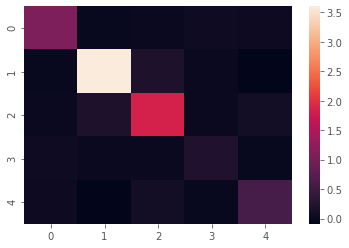

In [278]:
sns.heatmap(model_ZI.Sigma)

<AxesSubplot:>

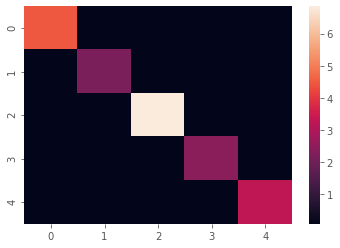

In [279]:
sns.heatmap(true_Sigma)

In [88]:
model_ZI.beta

tensor([[-3.2166, -0.7280, -1.2962, -0.6416, -1.7487],
        [-1.8429, -1.3648, -3.5495,  0.5688, -3.7605]])

In [89]:
true_beta

tensor([[-1.3986,  0.4033,  0.8380, -0.7193, -0.4033],
        [-0.5966,  0.1820, -0.8567,  1.1006, -1.0712]])

Parametrisation centered in $X\beta$ and variance $C$ 
$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

--------------
Parametrisation centered in $X\beta$ and variance $\Sigma$ 
$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

Parametrisation centered in 0 and unit variance. 
$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top}+\frac{ (S \odot S)(C\odot C)^{\top}}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

both closed : 1 
full param : 2
first_vem : 3
sigma_closed: 4
PCA : 5
beta clossed : 6
        

# Data generation

In [10]:
d = 2 # nb of cavariates
n = 15; p = 5

## Generate the true parameters and some data according to the true parameters. 

In [11]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = build_block_Sigma(p,4).to(device)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))/1
O =  0+torch.zeros((n,p))
true_B_zero = torch.randn((d,p)).to(device)
sample_model = sample_PLN(ZI = True)
Y_sampled, Z_sampled  = sample_PLN.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates, true_B_zero)
Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

<ipython-input-11-05986e619f53>:4: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  /opt/conda/conda-bld/pytorch_1637827623336/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1325.)
  true_C = torch.cholesky(true_Sigma)


TypeError: sample_PLN() missing 4 required positional arguments: 'Sigma', 'beta', 'O', and 'covariates'

In [357]:
torch.sum(Y_sampled==0)

tensor(104)

In [ ]:
dict_models_Rprop = launch_models(torch.optim.Rprop,N_iter = 5, lr = 0.5)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.77114
 MSE with beta :  1.42367
ELBO :  -109288716.04225
Delta :  -109288715.04224865


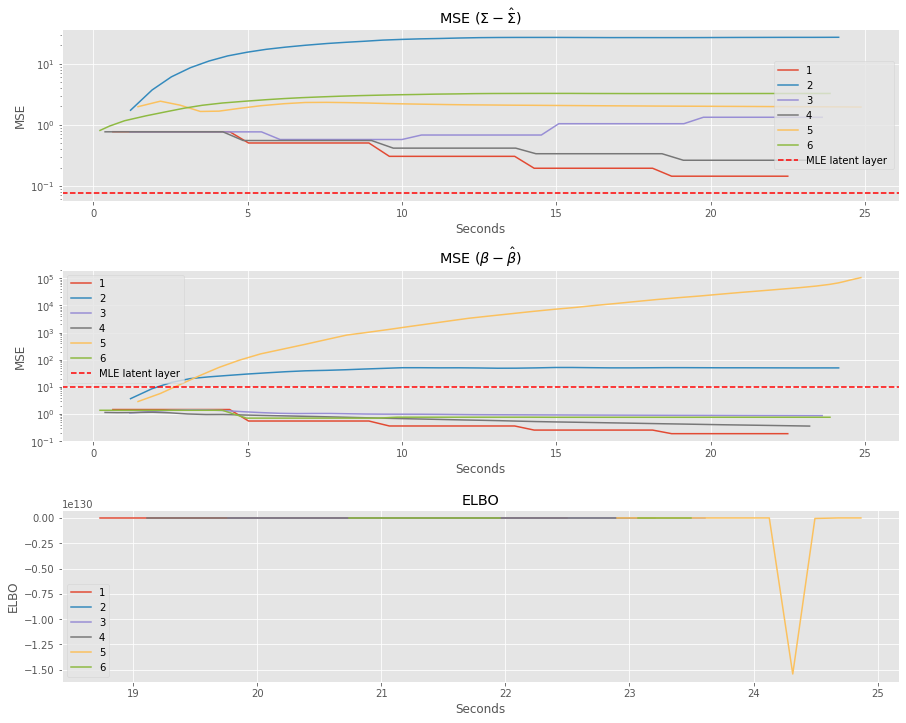

In [159]:
compare_models(dict_models_Rprop,'',percentage_kept = 0.2)

### Here we print the MLE for $\beta$ and $\Sigma$ in the latent layer 
Note that in practice we don't have access to the latent layer, but here we do since we generate the data ourselves. 

## $\Sigma$ MLE

MLE :


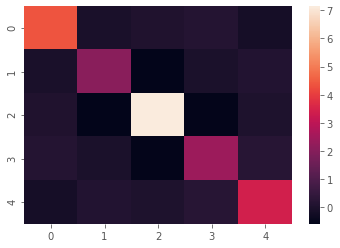

true Sigma


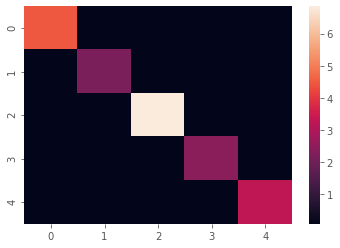

Best MSE we can have (in our dream):  tensor(0.0845)


In [54]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
plt.show()
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

<AxesSubplot:>

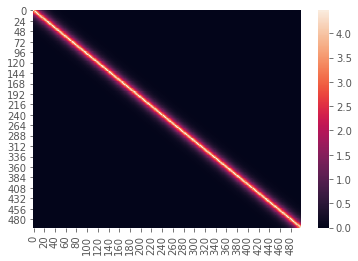

In [25]:
sns.heatmap(true_Sigma.to(torch.device('cpu'))[500:1000,500:1000])

### $\beta$ MLE

In [26]:
target = Z_sampled+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
best_MSE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer: ', best_MSE_beta)

MSE beta in the latent layer:  tensor(0.0237)


## best model : closed form for $\beta$ and $\Sigma$

In [55]:
best_model = PLN_full()
%time best_model.VEM_both_closed(data,Number_VEM_step =30,verbose=True, lr = 0.2, N_epoch_max = 1)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.54404
 MSE with beta :  0.93711
ELBO :  -10183.83546
Delta :  -10182.835456614921
---------------------------------Maximum number of iterations reached :  1 last delta =  -10182.835456614921
 MSE with Sigma :  2.54404
 MSE with beta :  0.93711
MSE with B_zero 1.00515
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.61325
 MSE with beta :  0.56303
ELBO :  -4662.19851
Delta :  5521.6369421878435
---------------------------------Maximum number of iterations reached :  1 last delta =  5521.6369421878435
 MSE with Sigma :  1.61325
 MSE with beta :  0.56303
MSE with B_zero 1.00515
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.81396
 MSE with beta :  0.49843
ELBO :  -1576.16057
Delta :  3086.0379476017383
---------------------------------Maximum number of iterations reached :  1 last delta =  3086.0379476017383
 MSE with Sigma :  1.81396
 MSE with beta :  0.49843
MSE with B_zero 1.00515
iteration num

## Comparison 

### We have many hyperparameters for the model, such as the learning rate, the optimizer, the parametrization  and the choice of the closed form update. We use threadings to go faster.  Allows to launch all the models at the same time. 

<AxesSubplot:>

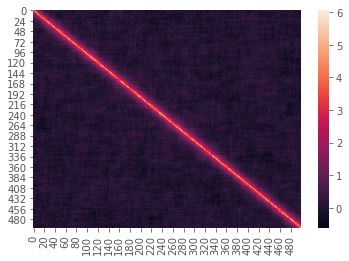

In [30]:
sns.heatmap(best_model.Sigma.detach()[0:500,0:500])

# Comparison of optimizer  

In [16]:
dict_optimizers = {'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                   'Adamax' : torch.optim.Adamax,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

In [17]:
dict_model_optim = launch_optimizers(dict_optimizers,10000,0.1)

NameError: name 'data' is not defined

In [18]:
compare_models(dict_model_optim,'', percentage_kept=0.1)

NameError: name 'dict_model_optim' is not defined

### Comparison of parametrization

In [122]:
#dict_models_adadelta = launch_models(torch.optim.Adadelta)
dict_models_Rprop = launch_models(torch.optim.Rprop,N_iter = 5, lr = 0.1)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  3.11121
 MSE with beta :  0.95566
ELBO :  -359749.69064
Delta :  -359748.6906408663
---------------------------------Maximum number of iterations reached :  8 last delta =  49091.320146861355
 MSE with Sigma :  3.11121
 MSE with beta :  0.95566
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.77316
 MSE with beta :  0.42546
ELBO :  139892.47483
Delta :  58514.52021552206
---------------------------------Maximum number of iterations reached :  8 last delta =  55790.89406920661
 MSE with Sigma :  2.77316
 MSE with beta :  0.42546
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.08201
 MSE with beta :  0.25582
ELBO :  576520.9884
Delta :  19231.976440686034
---------------------------------Maximum number of iterations reached :  8 last delta =  -1128.0329141359543
 MSE with Sigma :  1.08201
 MSE with beta :  0.25582
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.70847
 MSE with beta : 

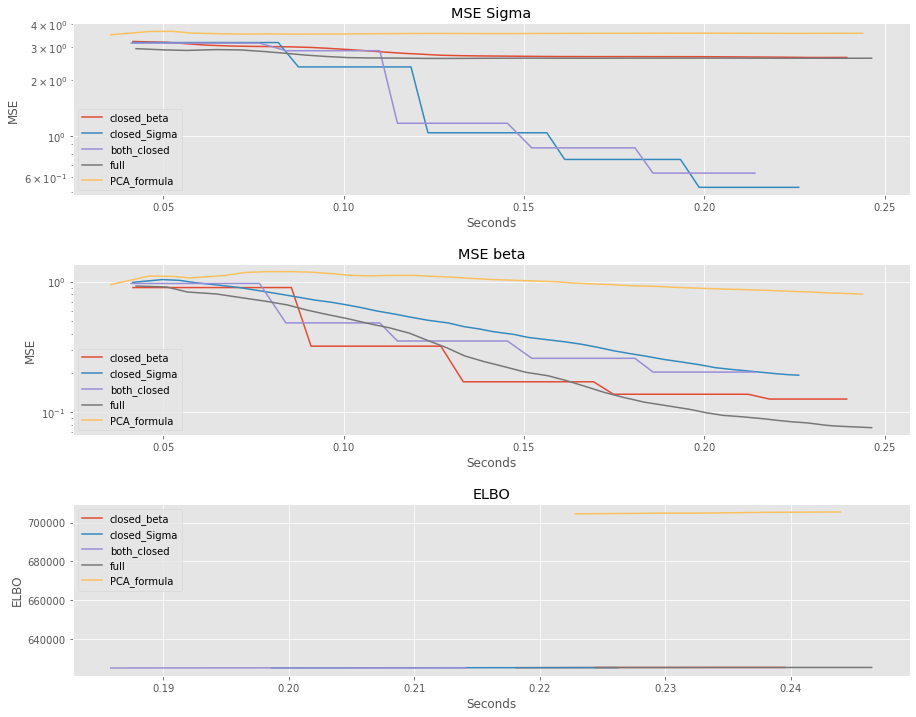

In [115]:
compare_models(dict_models_Rprop,'',percentage_kept = 0.2)

### comparison of learning rates

In [21]:
dict_lr = dict()

for i in range(6): 
    dict_lr['lr = '+ str(10**(-i))] = 10**(-i)

In [22]:
result_lr = launch_lr(dict_lr,10, optimizer = torch.optim.Rprop)

NameError: name 'data' is not defined

In [23]:
compare_models(result_lr,'comparison_lr_Rprop_both_closed',percentage_kept = 0.9, save = False)

NameError: name 'result_lr' is not defined

# All the different parametrisation

# Parametrisation centered in $X\beta$ and variance $CC^{\top}$

### VEM were we use only the closed form for  $\beta$ 

In [24]:
model_VEM_beta = PLN_full()
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =10,verbose=True, lr = 0.05)

NameError: name 'data' is not defined

### Gradient descent on all the parameters

In [25]:
model = PLN_full()
%time model.full_grad_ascent(data, N_epoch = 10,verbose=True, lr = 0.003)

NameError: name 'data' is not defined

# Parametrisation centered in $X\beta$ and variance $\Sigma$

### VEM were we use only the closed form for  $\Sigma$ 

In [26]:
model_VEM_Sigma = PLN_full()
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =10,verbose=True, lr = 1)

NameError: name 'data' is not defined

### VEM were we use the closed form for  $\beta$ and $\Sigma$. It is roughly a VEM algorithm. 

In [27]:
model_VEM = PLN_full()
%time model_VEM.VEM_both_closed(data,Number_VEM_step =10, N_epoch_max = 1,verbose=True, lr = 1)

NameError: name 'data' is not defined

# Parametrisation centered in $0$ and variance $I$


## Gradient descent with the PCA formula

In [28]:
model_PCA = PLN_full()
%time model_PCA.full_grad_ascent_PCA(data, N_epoch = 10,verbose=True, lr = 0.7)

NameError: name 'data' is not defined

# Parametrisation centered in 0 and variance Sigma

## VEM of the first notebook  

In [29]:
model_first_VEM = PLN_full()
%time model_first_VEM.first_VEM(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 1)

NameError: name 'data' is not defined

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\theta, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{i = 1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 

PARAMETRISATION CENTERED IN $X\beta$ and variance $\Sigma$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$



If we use $C$ instead of $\Sigma$ : 


PARAMETRISATION CENTERED IN $X\beta$ and variance $CC^{\top}$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{i} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+ ZC\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_i \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{j}^{\top} Z_i\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{j k}Z_{ik}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{j k} Z_{i k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{j k} Z_{i k}\right)\right] \\ 
&=\prod_{k=1}^{p} exp \left(M_{i_{k}} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&= \exp \left(\sum_{k=1}^{p} M_{i k} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&=\exp \left(M_{i}^{\top} C_{j}+\frac{\left(S_{i}^{2}\right)^{T} C_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top} +\frac{  (S \odot S)(C\odot C)^{\top}}{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

PARAMETRISATION CENTERED IN 0 AND UNIT VARIANCE 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top}+\frac{(S \odot S)(C\odot C)^{\top}}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

We have for the gradients : 

$$
\nabla_{\beta}=X^{\top} Y-\frac{1}{2} X^{\top} \exp \left(0+X \beta+M C^{\top}+\frac{\left(S\odot S\right)\left(C\odot C\right)^{\top}}{2}\right)
$$

We can have a last parametrization that is : 

$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$

and 


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$

This model is equivalent to the other ones but the optimization is different.  

PARAMETRISATION CENTERED IN 0 AND VARIANCE $\Sigma$

$$
\boxed{
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+ \sum_{i, j}-\frac 1 2\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|(S\odot S)_{i}\right|+c s t .
\end{aligned}}
$$
    

## test with the fastPLN file

In [30]:
from fastPLN import fastPLN 

device :  cpu


In [31]:
model = fastPLN()
model.fit(Y_sampled,O,covariates, 100)

NameError: name 'Y_sampled' is not defined

In [32]:
sns.heatmap(model.Sigma.detach().numpy())

AttributeError: 'fastPLN' object has no attribute 'Sigma'

## test with oaks data 


In [359]:
def f(theta): 
    return -torch.sum(torch.log(1+torch.exp(torch.mm(covariates, theta))))
def g(x): 
    return -x*logit(x)-torch.log(1-x)

def grad_g(x) : 
    return -logit(x)


In [364]:
theta = torch.randn(d,p, requires_grad = True)
x = torch.tensor([0.75], requires_grad = True)


In [372]:
loss = g(x)
loss.backward()
print('grad', x.grad)
print('my grad', grad_g(x))
x.grad*=0

grad tensor([-1.0986])
my grad tensor([-1.0986], grad_fn=<NegBackward>)


In [209]:
def grad_f(theta): 
    Xtheta = torch.mm(covariates,theta)
    return torch.mm(covariates.T, torch.div(torch.exp(Xtheta), 1+torch.exp(Xtheta)))

    
grad_f(theta)

tensor([[281.1064, 295.2080, 198.3130, 124.8110, 281.8457, 305.5304, 224.2386,
         116.5711, 180.8157, 368.1014],
        [299.7074, 292.1003, 203.9590, 120.8637, 278.4970, 312.6037, 206.0219,
         121.5603, 132.9053, 384.3828]], grad_fn=<MmBackward>)